# MNIST- handwritten digit recognition
[The MNIST problem](http://yann.lecun.com/exdb/mnist/) is a dataset developed by Yann LeCun, Corinna Cortes and Christopher
Burges for evaluating machine learning models on the handwritten digit classification problem.
The dataset was constructed from a number of scanned document datasets available from the
National Institute of Standards and Technology (NIST). This is where the name for the dataset
comes from, as the Modified NIST or MNIST dataset.
Images of digits were taken from a variety of scanned documents, normalized in size and
centered. This makes it an excellent dataset for evaluating models, allowing the developer to
focus on the machine learning with very little data cleaning or preparation required. Each
image is a 28 × 28 pixel square (784 pixels total).
The dataset below has 60000 images for training and 10000 for testing. Labels are the 10 digits (0-9), therefore it is a multi-class classification problem. Excellent results achieve a prediction error of less than 1%. State-of-the-art prediction
error of approximately 0.2% can be achieved with large Convolutional Neural Networks.

## Loading Data & EDA

In [241]:
from keras.datasets import mnist
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

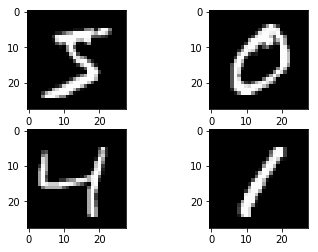

In [242]:
# fix random seed for reproducibility
seed = 123
np.random.seed(seed)
# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()
# plot 4 images as gray scale
plt.subplot(221)
plt.imshow(X_train[0], cmap='gray')
plt.subplot(222)
plt.imshow(X_train[1], cmap='gray') 
plt.subplot(223)
plt.imshow(X_train[2], cmap='gray')
plt.subplot(224)
plt.imshow(X_train[3], cmap='gray')
# show the plot
plt.show()

In [243]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)
print(X_train.max(), X_train.min()) # Note that the pixel value scales 0-255 

(60000, 28, 28) (60000,) (10000, 28, 28) (10000,)
255 0


## Baseline model using simple neural net
MNIST problem is not terribly difficult that we may get a decent result by using simple neural nets without CNN. We can build a baseline model with a simple neural net and later compare how a CNN model does better that the baseline.

A simple NN talkes 1D input, so we will change the data shape to a 1D vector: a 2D image of 28x28 pixels is reshaped (flattened) to a 1D vector of 784 pixels. Then the pixel values are normalized so that a value is between 0 and 1. Then we make labels (both y_train and y_test) to categorical- which means we make 10 columns with values 0 or 1 instead of 1 column with values 0-9.     


In [244]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
import keras.utils as np_utils

# fix random seed for reproducibility
seed = 123
np.random.seed(seed)

# load (downloaded if needed) the MNIST dataset
(X_train, y_train), (X_test, y_test) = mnist.load_data()

# flatten 28*28 images to a 784 vector for each image
num_pixels = X_train.shape[1] * X_train.shape[2]
X_train = X_train.reshape(X_train.shape[0], num_pixels).astype('float32')
X_test = X_test.reshape(X_test.shape[0], num_pixels).astype('float32')

# normalize inputs from 0-255 to 0-1
X_train = X_train / 255
X_test = X_test / 255

# one hot encode outputs
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_test)
num_classes = y_test.shape[1]


In [245]:
# define baseline model
def baseline_model():
    model = Sequential()
    model.add(Dense(1,input_shape=(784,),activation='relu'))
    model.add(Dense(10, activation = 'sigmoid'))
    model.compile(loss= 'categorical_crossentropy' , optimizer= 'adam' , metrics=[ 'accuracy' ])
    return model

# build the model
model = baseline_model()
# Fit the model
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=20, batch_size=200, verbose=2)
# Final evaluation of the model
scores = model.evaluate(X_test, y_test, verbose=0)
print("Baseline Error: %.2f%%" % (100-scores[1]*100))

Train on 60000 samples, validate on 10000 samples
Epoch 1/20
 - 3s - loss: 2.1766 - acc: 0.1354 - val_loss: 2.1098 - val_acc: 0.1354
Epoch 2/20
 - 1s - loss: 2.0554 - acc: 0.1668 - val_loss: 2.0134 - val_acc: 0.1717
Epoch 3/20
 - 1s - loss: 1.9770 - acc: 0.2047 - val_loss: 1.9544 - val_acc: 0.2485
Epoch 4/20
 - 1s - loss: 1.9257 - acc: 0.2390 - val_loss: 1.9122 - val_acc: 0.2373
Epoch 5/20
 - 1s - loss: 1.8887 - acc: 0.2386 - val_loss: 1.8808 - val_acc: 0.2394
Epoch 6/20
 - 1s - loss: 1.8604 - acc: 0.2448 - val_loss: 1.8565 - val_acc: 0.2542
Epoch 7/20
 - 1s - loss: 1.8377 - acc: 0.2502 - val_loss: 1.8356 - val_acc: 0.2594
Epoch 8/20
 - 1s - loss: 1.8187 - acc: 0.2511 - val_loss: 1.8183 - val_acc: 0.2664
Epoch 9/20
 - 1s - loss: 1.8018 - acc: 0.2657 - val_loss: 1.8022 - val_acc: 0.2467
Epoch 10/20
 - 1s - loss: 1.7862 - acc: 0.2639 - val_loss: 1.7874 - val_acc: 0.2977
Epoch 11/20
 - 2s - loss: 1.7713 - acc: 0.2635 - val_loss: 1.7733 - val_acc: 0.2676
Epoch 12/20
 - 2s - loss: 1.7578 - 

## Simple CNN model
Now we will build a simple CNN model and see if it can do better than our baseline model above (NN without convolution layer).

In [246]:
# Simple CNN for the MNIST Dataset
import numpy
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
import keras.utils as np_utils
from keras import backend as K

K.set_image_dim_ordering('tf')

# fix random seed for reproducibility
seed = 123
numpy.random.seed(seed)

# load data
(X_train, y_train), (X_test, y_test) = mnist.load_data()

print(X_train.shape)
print(X_test.shape)

(60000, 28, 28)
(10000, 28, 28)


In [247]:
#### YOUR TURN
# Reshape X_train and X_test to be (n_samples, width, height, channels)
# Then cast the data type of the arrays to type 'float32'
# Hint: the n_channel is 1 in this case. You can use .shape
# Hint: .astype() changes numpy array's data type

X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)).astype('float32')

print(X_train.shape)

X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)).astype('float32')

print(X_test.shape)

(60000, 28, 28, 1)
(10000, 28, 28, 1)


In [248]:
### YOUR TURN
# Normalize inputs from 0-255 to 0-1
X_train = X_train /255
X_test = X_test / 255

# Encode labels to categorical
y_train = np_utils.to_categorical(y_train)
y_test = np_utils.to_categorical(y_train)
num_classes = y_test.shape[1]


In [249]:
from keras.layers import Convolution2D, MaxPooling2D

# create model
### YOUR TURN
# Build a model that has 1 convolution layer, 1 max pooling, 1 dense, and output 
# Use 32 filters with 5x5 size
# For max pooling layer, make the layer such that the featuremap size would be the half after the pooling layer
# hint: you need to change the argument input_shape to (w,h,1) in the first conv layer
# hint: you need Flatten() before the first dense layer
# Compile the model using the same options as above

# define a simple CNN model
def simple_cnn_model():
    model = Sequential()
    model.add(Convolution2D(32, kernel_size = (5,5), activation='relu', input_shape=(28,28,1)))
    model.add(Convolution2D(32, kernel_size = (5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='sigmoid'))
    model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])
    return model

# build the model
model = simple_cnn_model()

print(model.output_shape)


(None, 10)


In [250]:
# Fit the model
model.fit(X_train, y_train, epochs=10, batch_size=200, verbose=1)
#model.fit(X_train, y_train, batch_size=32, epochs=10, verbose=1)

# Final evaluation of the model
#scores = model.evaluate(X_test, y_test, verbose=0)
#print("CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/10
60000/60000 [==============================] - 266s 4ms/step - loss: 0.3484 - acc: 0.9042
Epoch 2/10
60000/60000 [==============================] - 234s 4ms/step - loss: 0.0989 - acc: 0.9728
Epoch 3/10
60000/60000 [==============================] - 214s 4ms/step - loss: 0.0674 - acc: 0.9804
Epoch 4/10
60000/60000 [==============================] - 214s 4ms/step - loss: 0.0532 - acc: 0.9850
Epoch 5/10
60000/60000 [==============================] - 215s 4ms/step - loss: 0.0447 - acc: 0.9875
Epoch 6/10
60000/60000 [==============================] - 213s 4ms/step - loss: 0.0385 - acc: 0.9884
Epoch 7/10
60000/60000 [==============================] - 211s 4ms/step - loss: 0.0330 - acc: 0.9896
Epoch 8/10
60000/60000 [==============================] - 211s 4ms/step - loss: 0.0291 - acc: 0.9912
Epoch 9/10
60000/60000 [==============================] - 211s 4ms/step - loss: 0.0256 - acc: 0.9917
Epoch 10/10
60000/60000 [==============================] - 211s 4ms/step - loss: 0.0243 - a

## Two-layer CNN model
Let's stack another convolutional layer.

In [251]:
# YOUR TURN
# Build a 2-conv layer model
# Try this architecture: conv-maxpool-conv-maxpool-dense-dense-output
# Use 32 (5x5) filters for the first conv layer, and use 16 (3x3) filters for the second conv layer
# Use the same max pool as above
# (optional) you can compare with and with out dropout layer after the second maxpool layer
# Usng dropout is a way to regularize your model. Dropout randomly drops some neurons in the feature map.
# By dropping out some units, it effectively makes the model smaller so it helps reducing the overfitting. 
# see https://keras.io/layers/core/#dropout for the use
# Use 1-2 dense layers before the output

def bilayer_model():
    # create model
    model = Sequential()
    model.add(Convolution2D(32, kernel_size = (5,5), activation='relu', input_shape=(28,28,1)))
    model.add(Convolution2D(32, kernel_size = (3,3), activation='relu'))
    model.add(MaxPooling2D(pool_size=(1,1)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dropout(0.5))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])
    return model
   
# build the model
model = bilayer_model()

In [252]:
# Fit the model
model.fit(X_train, y_train, epochs=20, batch_size=200, verbose=2)

# Final evaluation of the model
#scores = model.evaluate(X_test, y_test, verbose=0)
#print("Large CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/20
 - 125s - loss: 0.4137 - acc: 0.8723
Epoch 2/20
 - 124s - loss: 0.1147 - acc: 0.9708
Epoch 3/20
 - 125s - loss: 0.0830 - acc: 0.9792
Epoch 4/20
 - 124s - loss: 0.0622 - acc: 0.9842
Epoch 5/20
 - 124s - loss: 0.0538 - acc: 0.9865
Epoch 6/20
 - 124s - loss: 0.0464 - acc: 0.9879
Epoch 7/20
 - 124s - loss: 0.0370 - acc: 0.9903
Epoch 8/20
 - 124s - loss: 0.0335 - acc: 0.9915
Epoch 9/20
 - 124s - loss: 0.0289 - acc: 0.9923
Epoch 10/20
 - 124s - loss: 0.0227 - acc: 0.9934
Epoch 11/20
 - 124s - loss: 0.0235 - acc: 0.9939
Epoch 12/20
 - 125s - loss: 0.0200 - acc: 0.9942
Epoch 13/20
 - 124s - loss: 0.0213 - acc: 0.9943
Epoch 14/20
 - 124s - loss: 0.0192 - acc: 0.9945
Epoch 15/20
 - 124s - loss: 0.0159 - acc: 0.9957
Epoch 16/20
 - 124s - loss: 0.0128 - acc: 0.9963
Epoch 17/20
 - 124s - loss: 0.0122 - acc: 0.9962
Epoch 18/20
 - 124s - loss: 0.0154 - acc: 0.9955
Epoch 19/20
 - 124s - loss: 0.0140 - acc: 0.9960
Epoch 20/20
 - 124s - loss: 0.0103 - acc: 0.9969


## More convolution layers 

In [253]:
def multilayer_cnn_model():
    # create model
    model = Sequential()
    model.add(Convolution2D(32, kernel_size = (10,10), activation='relu', input_shape=(28,28,1)))
    model.add(Convolution2D(32, kernel_size = (5,5), activation='relu'))
    model.add(MaxPooling2D(pool_size=(3,3)))
    model.add(Dropout(0.10))
    model.add(Flatten())
    model.add(Dense(50, activation='relu'))
    model.add(Dense(100, activation = 'relu'))
    model.add(Dense(50, activation = 'relu'))
    model.add(Dropout(0.25))
    model.add(Dense(10, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])
    return model

# build the model
model = multilayer_cnn_model()


In [254]:
# Fit the model
model.fit(X_train, y_train, epochs=20, batch_size=200, verbose=2)
# Final evaluation of the model
#scores = model.evaluate(X_test, y_test, verbose=0)
#print("CNN Error: %.2f%%" % (100-scores[1]*100))

Epoch 1/20
 - 121s - loss: 0.4082 - acc: 0.8723
Epoch 2/20
 - 121s - loss: 0.1062 - acc: 0.9700
Epoch 3/20
 - 120s - loss: 0.0749 - acc: 0.9792
Epoch 4/20
 - 121s - loss: 0.0588 - acc: 0.9832
Epoch 5/20
 - 120s - loss: 0.0499 - acc: 0.9860
Epoch 6/20
 - 120s - loss: 0.0431 - acc: 0.9880
Epoch 7/20
 - 120s - loss: 0.0366 - acc: 0.9903
Epoch 8/20
 - 120s - loss: 0.0310 - acc: 0.9914
Epoch 9/20
 - 120s - loss: 0.0272 - acc: 0.9923
Epoch 10/20
 - 120s - loss: 0.0263 - acc: 0.9919
Epoch 11/20
 - 120s - loss: 0.0231 - acc: 0.9934
Epoch 12/20
 - 121s - loss: 0.0225 - acc: 0.9932
Epoch 13/20
 - 121s - loss: 0.0178 - acc: 0.9947
Epoch 14/20
 - 120s - loss: 0.0195 - acc: 0.9942
Epoch 15/20
 - 120s - loss: 0.0183 - acc: 0.9948
Epoch 16/20
 - 120s - loss: 0.0163 - acc: 0.9953
Epoch 17/20
 - 120s - loss: 0.0162 - acc: 0.9950
Epoch 18/20
 - 120s - loss: 0.0145 - acc: 0.9956
Epoch 19/20
 - 120s - loss: 0.0144 - acc: 0.9958
Epoch 20/20
 - 120s - loss: 0.0116 - acc: 0.9963


Discussion:
Give bullet pints summary of what you have found from above experiments.
e.g. 
- how is a 1-layer ANN vs. 1-layer CNN?
    * a one layer ANN performs much worse, but much faster than a convolutional neural network. In comparison would be 36% accuracy to 99.7%
- when the number of layers increases, what happens to the performance?
    * when the number of layers increases, the performance improves, however does leave risk for overfitting
- what happens if I have very deep CNN? did you face with any problems?
    * the deeper the cnn, the greater the computational power it took to run. The accuracy of a simple CNN was nearly perfect, but operated much quicker
- what can you do to reduce an overfitting problem?
    * to reduce overfitting we can use stride, pooling and drop out. Each of which help reduce smaller sensitities to averages/min/max/sum or cross pool relationships
- search internet and list other ways to reduce overfitting in CNN
    * Steps for reducing overfitting via <https://towardsdatascience.com/deep-learning-3-more-on-cnns-handling-overfitting-2bd5d99abe5d>:
        1. Add more data
        2. Use data augmentation
        3. Use architectures that generalize well
            * pooling
            * stride
            * not too specific of depth
            * normalization
        4. Add regularization (mostly dropout, L1/L2 regularization are also possible)
        5. Reduce architecture complexity.